# Assignment 2: Cardiovascular Risk
Alex Reese, Scott Ratchford, Ben Fioresi

# Introduction
In this lab, we worked with patient health data about heart disease. Our mission was to predict which patients would die from heart failure.

Our approach will involve two main steps:
1.	Creating visualizations using `matplotlib`, which will allow us to immediately identify any significant factors affecting the `DEATH_EVENT` status.
2.	Then, we will analyze the data further using TensorFlow Decision Forests, TensorFlow Random Forests, and scikit-learn K-Nearest Neighbors to determine if these can effectively predict the `DEATH_EVENT` status. To achieve this, we will:
    * Experiment with different methods of preparing the data for training, using `scikit-learn`.
    * Utilize hyperparameter tuners to explore various combinations of parameters.
    * Compare and contrast the results of each model and its optimizations. 

In [2]:
!pip install tensorflow_decision_forests

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import tensorflow_decision_forests as tfdf
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Custom class for simple collection of model performance
class PerformanceMetrics:
    """
    # Example usage of PerformanceMetrics (define a model first)
    """
    def __init__(self, name: str, model, test_dataframe) -> None:
        self.name = name
        # evaulates the model and saves key metrics
        if isinstance(model, tfdf.keras.RandomForestModel):
            # convert the testing data to TensorFlow dataset
            test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataframe, task=tfdf.keras.Task.CLASSIFICATION, label="DEATH_EVENT")
            # predict class values
            predictions_proba = model.predict(test_ds).flatten()
            predicted_classes = (predictions_proba > 0.5).astype(int)
        elif isinstance(model, DecisionTreeClassifier):
            test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataframe, task=tfdf.keras.Task.CLASSIFICATION, label="DEATH_EVENT")
            # predict class values
            predictions_proba = model.predict(test_dataframe.drop(columns=("DEATH_EVENT"))).flatten()
            predicted_classes = model.predict(test_dataframe.drop(columns=("DEATH_EVENT")))
        elif isinstance(model, Pipeline) or isinstance(model, GridSearchCV):
            # predict class values
            predictions_proba = model.predict(test_dataframe.drop(columns=("DEATH_EVENT"))).flatten()
            predicted_classes = model.predict(test_dataframe.drop(columns=("DEATH_EVENT")))
        else:
            raise TypeError("model is not of type tfdf.keras.RandomForestModel, sklearn.tree.DecisionTreeClassifier, sklearn.pipeline.Pipeline, or sklearn.model_selection.GridSearchCV")

        # perform calculations to determine metrics
        true_labels = test_dataframe["DEATH_EVENT"].values
        # the important evaluation metrics
        self.accuracy = accuracy_score(true_labels, predicted_classes)
        self.precision = precision_score(true_labels, predicted_classes)
        self.recall = recall_score(true_labels, predicted_classes)
        self.f1 = f1_score(true_labels, predicted_classes)
        self.roc_auc = roc_auc_score(true_labels, predictions_proba)  # Note: Here we use the probabilities, not the thresholded predictions
        self.conf_matrix = confusion_matrix(true_labels, predicted_classes)
    
    def __str__(self) -> str:
        return f"{self.name} Performance Metrics\nAccuracy: {self.accuracy}\nPrecision: {self.precision}\nRecall: {self.recall}\nF1 Score: {self.f1}\nROC AUC: {self.roc_auc}\nConfusion Matrix:\n{self.conf_matrix}"



2023-11-30 18:05:21.344741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 18:05:22.390835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Loading the Dataset

In [4]:
import pandas as pd
import math

# Load the dataset into a dataframe
data = pd.read_csv('Heart_failure_dataset.csv', encoding = "utf-8-sig")

int_cols = ("age", "creatine_phosphokinase", "ejection_fraction", "platelets", "serum_sodium", "time")
bool_cols = ("anaemia", "diabetes", "high_blood_pressure", "sex", "smoking")
# Delete the cells containing data that seems errorneous
for col_name, col in data.items():
    if col_name in int_cols:
        for cell in col:
            if not math.isclose(cell, int(cell)):   # drop cells with decimals
                cell = None
    if col_name in bool_cols:
        for cell in col:
            if cell != 0 and cell != 1:   # drop cells that aren't 0 or 1
                cell = None

## Data Visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("whitegrid")

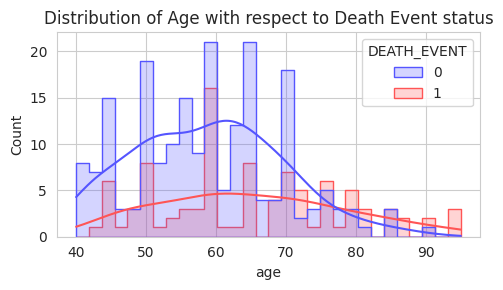

In [6]:
# Plot the distribution of the 'age' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='age', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Age with respect to Death Event status')
plt.tight_layout()
plt.show()

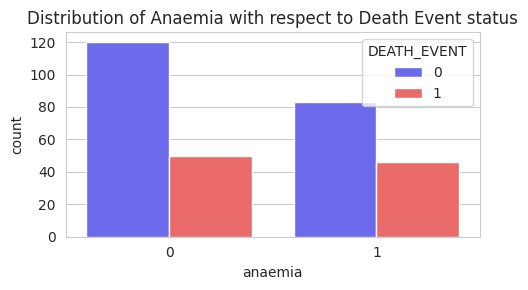

In [7]:
# Plot the distribution of the 'anaemia' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='anaemia', hue='DEATH_EVENT', palette='seismic', order=data['anaemia'].value_counts().index)
plt.title('Distribution of Anaemia with respect to Death Event status')
plt.tight_layout()
plt.show()

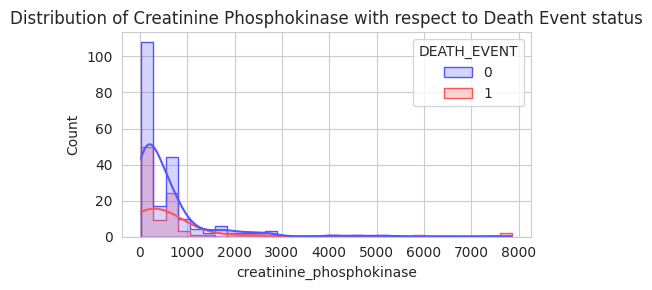

In [8]:
# Plot the distribution of the 'creatinine_phosphokinase' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='creatinine_phosphokinase', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Creatinine Phosphokinase with respect to Death Event status')
plt.tight_layout()
plt.show()

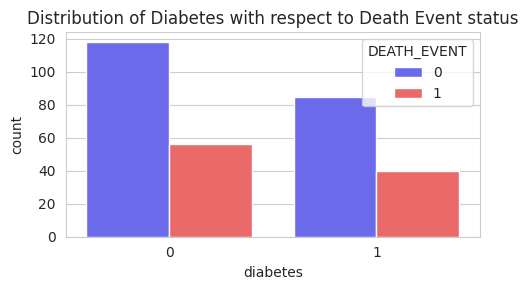

In [9]:
# Plot the distribution of the 'diabetes' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='diabetes', hue='DEATH_EVENT', palette='seismic', order=data['diabetes'].value_counts().index)
plt.title('Distribution of Diabetes with respect to Death Event status')
plt.tight_layout()
plt.show()

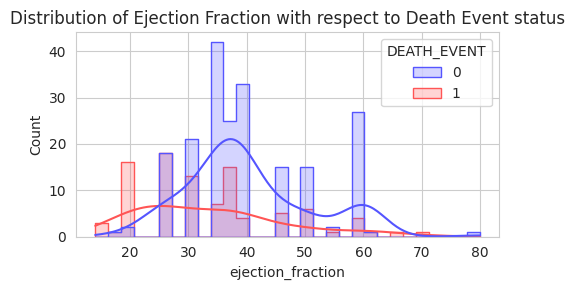

In [10]:
# Plot the distribution of the 'ejection_fraction' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='ejection_fraction', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Ejection Fraction with respect to Death Event status')
plt.tight_layout()
plt.show()

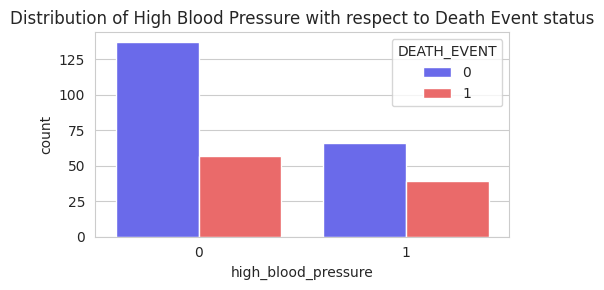

In [11]:
# Plot the distribution of the 'high_blood_pressure' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='high_blood_pressure', hue='DEATH_EVENT', palette='seismic', order=data['diabetes'].value_counts().index)
plt.title('Distribution of High Blood Pressure with respect to Death Event status')
plt.tight_layout()
plt.show()

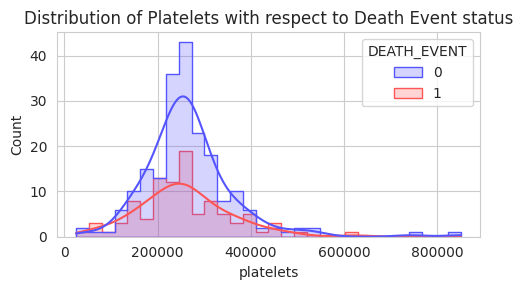

In [12]:
# Plot the distribution of the 'platelets' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='platelets', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Platelets with respect to Death Event status')
plt.tight_layout()
plt.show()

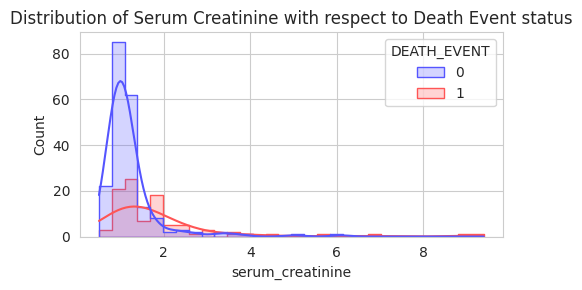

In [13]:
# Plot the distribution of the 'serum_creatinine' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='serum_creatinine', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Serum Creatinine with respect to Death Event status')
plt.tight_layout()
plt.show()

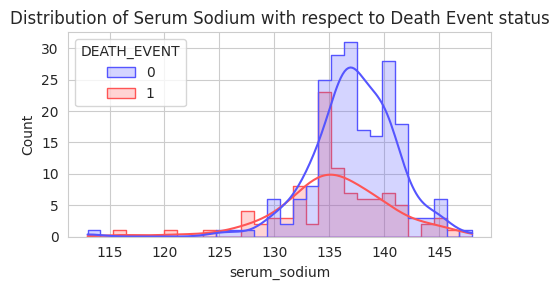

In [14]:
# Plot the distribution of the 'serum_sodium' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='serum_sodium', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Serum Sodium with respect to Death Event status')
plt.tight_layout()
plt.show()

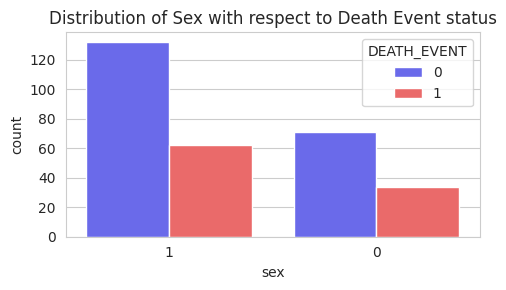

In [15]:
# Plot the distribution of the 'sex' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='sex', hue='DEATH_EVENT', palette='seismic', order=data['sex'].value_counts().index)
plt.title('Distribution of Sex with respect to Death Event status')
plt.tight_layout()
plt.show()

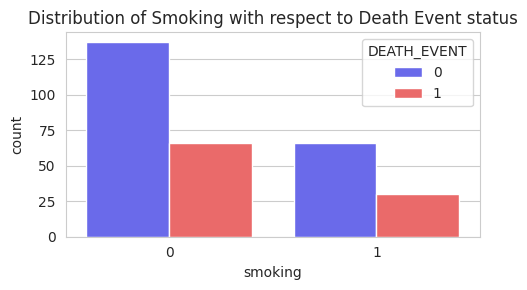

In [16]:
# Plot the distribution of the 'smoking' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='smoking', hue='DEATH_EVENT', palette='seismic', order=data['smoking'].value_counts().index)
plt.title('Distribution of Smoking with respect to Death Event status')
plt.tight_layout()
plt.show()

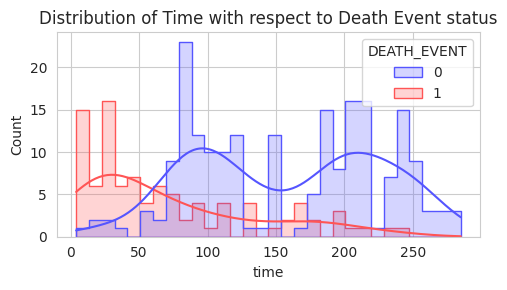

In [17]:
# Plot the distribution of the 'time' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='time', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Time with respect to Death Event status')
plt.tight_layout()
plt.show()

# Data Preprocessing

## Unused Columns
These columns will be dropped at a later point to prevent the models from using irrelevant data.

`time`: Because this is simply a measurement of when the patient was tested, this is irrelevant to the patient's health. Accuracy of the optimized models greatly improves without this feature, as expected.

In [18]:
# print(data.columns)
unused_columns = ["time"]
data = data.drop(columns=[_ for _ in unused_columns])

## Train/Test Split

We use the same train/test data split to evaluate the default hyperparameter configuration of every model. 80% of the data set is used for training models, while 20% is reserved for testing. The training and test data are saved in their respective CSV files.

In [19]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=62)

# Save the training and test datasets to CSV files
train_data.to_csv('train_data.csv', index=False, encoding="utf-8-sig")
test_data.to_csv('test_data.csv', index=False, encoding="utf-8-sig")

# Random Forest Model

### Default Hyperparameters

In [20]:
import tensorflow_decision_forests as tfdf

# Load the training dataset
train_df = pd.read_csv('train_data.csv', encoding = "utf-8-sig")

# Convert the training data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="DEATH_EVENT")

# Create a Random Forest model
rf_model = tfdf.keras.RandomForestModel()
rf_model.fit(train_ds)

2023-11-30 18:05:26.487075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:26.613275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:26.613378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:26.615946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:26.616019: I tensorflow/compile

Use /tmp/tmp2xn5fxty as temporary training directory
Reading training dataset...


r/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:27.504490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:27.504781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-30 18:05:27.504790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-11-30 18:05:27.504862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to r

Training dataset read in 0:00:02.535042. Found 239 examples.
Training model...
Model trained in 0:00:00.073668
Compiling model...


[INFO 23-11-30 18:05:30.3997 CST kernel.cc:1243] Loading model from path /tmp/tmp2xn5fxty/model/ with prefix ddbd85a6bafe4358
[INFO 23-11-30 18:05:30.4161 CST decision_forest.cc:660] Model loaded with 300 root(s), 14552 node(s), and 11 input feature(s).
[INFO 23-11-30 18:05:30.4161 CST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-11-30 18:05:30.4161 CST kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


### Hyperparameter Optimization

In [21]:
# Load the training dataset
train_df = pd.read_csv('train_data.csv', encoding = "utf-8-sig")

# Convert the training data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="DEATH_EVENT")

# Configure the tuner
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("max_depth", list(range(3, 100)))
tuner.choice("num_trees", list(range(10, 500)))

# Configure and train the model.
rf_adv_model = tfdf.keras.RandomForestModel(tuner=tuner)
rf_adv_model.fit(train_ds)

Use /tmp/tmpe49j6277 as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.159079. Found 239 examples.
Training model...
Model trained in 0:00:06.849451
Compiling model...
Model compiled.


[INFO 23-11-30 18:05:38.4430 CST kernel.cc:1243] Loading model from path /tmp/tmpe49j6277/model/ with prefix e1fe02987c5848d3
[INFO 23-11-30 18:05:38.4448 CST decision_forest.cc:660] Model loaded with 10 root(s), 488 node(s), and 11 input feature(s).
[INFO 23-11-30 18:05:38.4448 CST kernel.cc:1075] Use fast generic engine


# Decision Tree Classifier (Decision Forest)

In [22]:
!pip install tensorflow_decision_forests

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Training Decision Tree Model

### Default Hyperparameters

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=62) # use the same random state on every run
# train decision tree model to predict DEATH_EVENT
dt_model.fit(train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values)
print(f"Depth: {dt_model.get_depth()}")

Depth: 13


### Hyperparameter Optimization

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_adv_model = DecisionTreeClassifier()
# hyperparameters to try
dt_hyperparameters = {
    "max_depth": range(3, 15),
    "max_leaf_nodes": (None,),
    # "max_leaf_nodes": range(2, 999),
    "random_state": (62,),  # maintain state between runs
}

dt_clf = GridSearchCV(dt_adv_model, dt_hyperparameters, n_jobs=-1)

dt_adv_model = dt_clf.fit(data.drop(columns=["DEATH_EVENT"]), data["DEATH_EVENT"].values)
dt_adv_model = dt_adv_model.best_estimator_

## Visualizing Decision Tree Process

In [25]:
!pip install dtreeviz

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Default Hyperparameter Visualization

/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


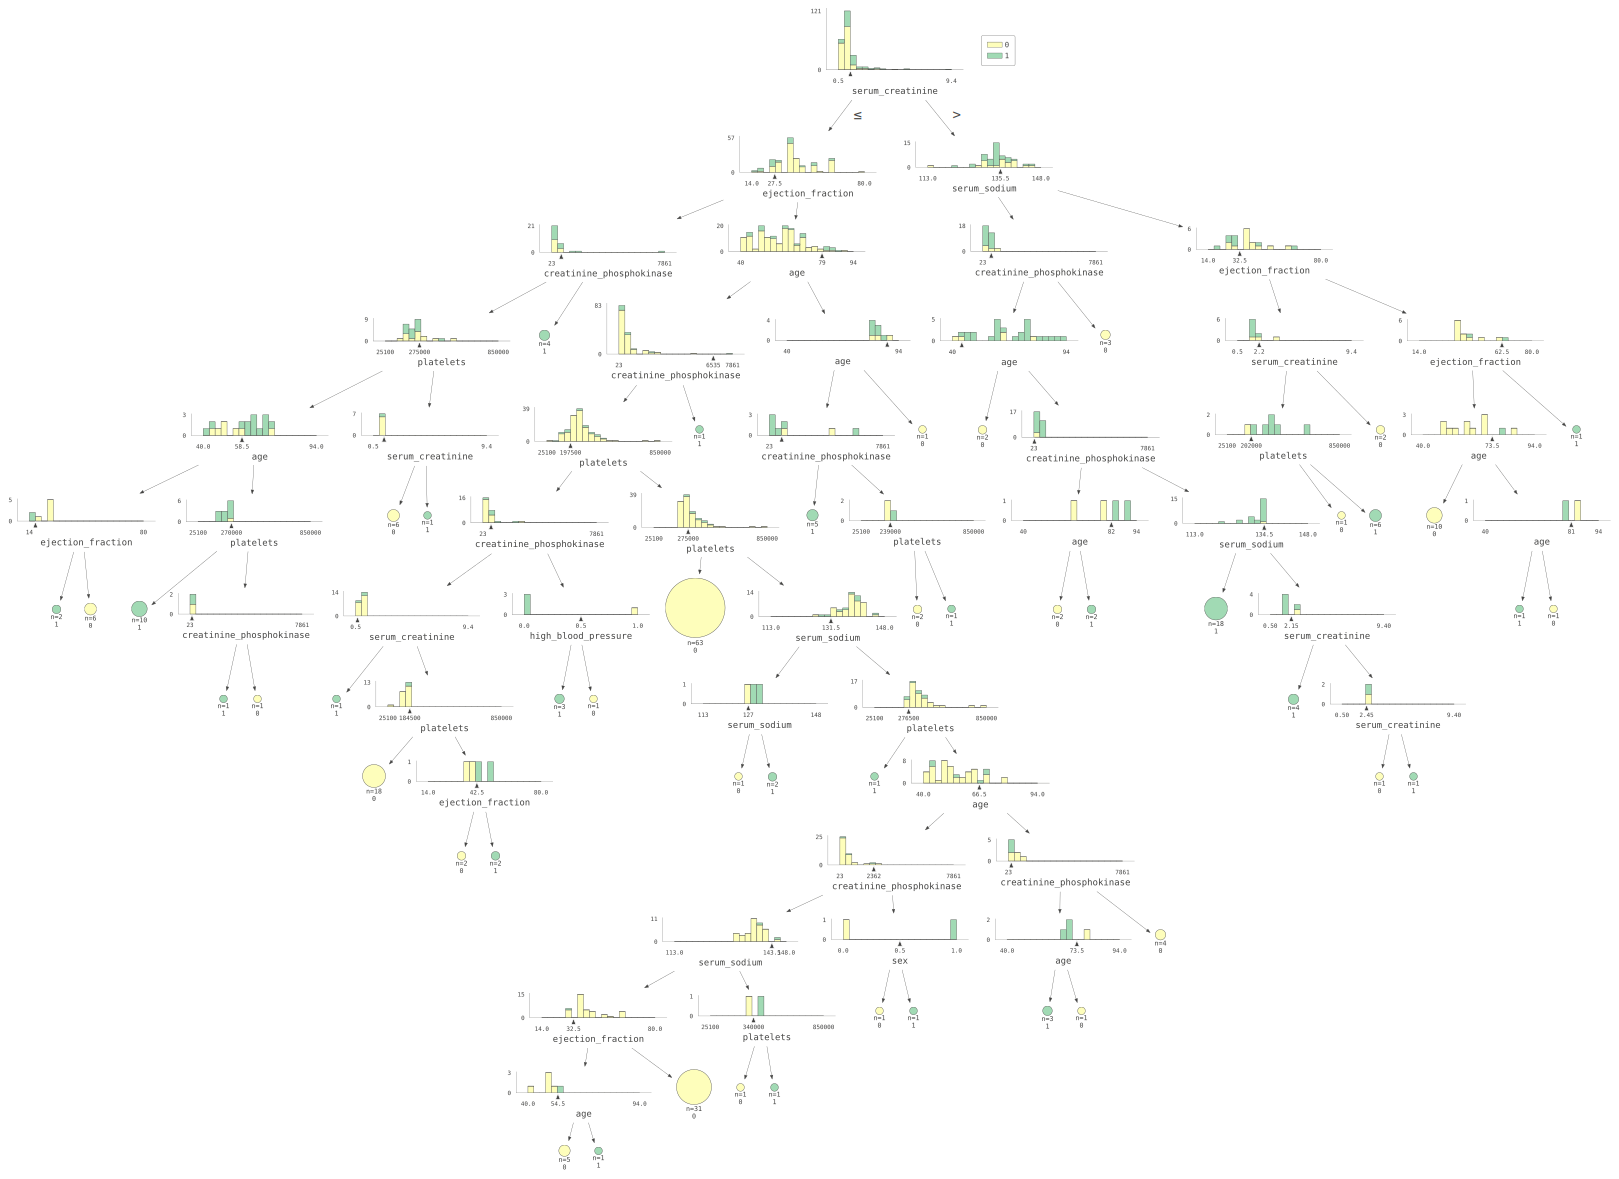

In [33]:
import dtreeviz

viz_cmodel = dtreeviz.model(dt_model, train_data.drop(columns=["DEATH_EVENT"]), train_data["DEATH_EVENT"].values, class_names=("0", "1"), feature_names=train_data.columns)
viz_cmodel.view(fontname="monospace")

### Optimized Hyperparameter Optimization

/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


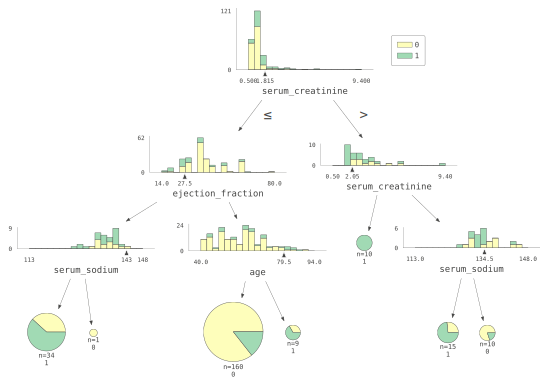

In [42]:
import dtreeviz

viz_cmodel = dtreeviz.model(dt_adv_model, train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values, class_names=("0", "1"), feature_names=train_data.columns)
viz_cmodel.view(fontname="monospace")

# K-Nearest Neighbor Classifier

### Default Hyperparameters

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_model = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_model.fit(train_data.drop(columns=["DEATH_EVENT"]), train_data["DEATH_EVENT"].values)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

### Hyperparameter Optimization

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_adv_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 10),
    "leaf_size": range(20, 41),
    "p": range(2, 10),
    "weights": ("distance", "uniform",),
    "algorithm": ("ball_tree", "kd_tree", "auto",),
}

knn_clf = GridSearchCV(knn_adv_model, knn_hyperparameters, n_jobs=-1)

knn_adv_model = knn_clf.fit(data.drop(columns=["DEATH_EVENT"]), data["DEATH_EVENT"].values)


## All Model Evaluations

### Default Hyperparameter Comparison
These models are trained using the default hyperparameter values for their respective types. These results are very poor for any machine learning result.

It seems that TensorFlow's default Random Forest configuration would perform better with additional features, given the relatively small number of features in this data set. The default number of trees, 300, is excessive for a data set with a mere 13 features (counting dropped fields and DEATH_EVENT, which were not included in the training set). There are fewer patients in the data set than the default number of trees.

A Decision Tree with the default parameters performs the worst of any attempted model, due to its unbounded depth. The natural tendency of the algorithm is to make itself as complex as possible, increasing its depth for little to no gain. This often harms the generality of the model. Needlessly high depth is an indication of overfitting.

The K-Nearest Neighbors algorithm lacks the number of data points it needs to perform well. At 299 data points, the KNN algorithm struggles to effectively classify any data points. It barely performs better than random chance, and fine-tuning the model does not improve its accuracy at all.

In [30]:
# Load the testing dataset
temp_df = pd.read_csv("test_data.csv", encoding = "utf-8-sig")

# Random Forest Classifier
rf_metrics = PerformanceMetrics("Random Forest Classifier", rf_model, temp_df)
print(str(rf_metrics) + "\n")

# Decision Tree Classifier
dt_metrics = PerformanceMetrics("Decision Tree Classifier", dt_model, temp_df)
print(str(dt_metrics) + "\n")

# K-Nearest Neighbors Classifier
knn_metrics = PerformanceMetrics("K-Nearest Neighbors Classifier", knn_model, temp_df)
print(str(knn_metrics))

1/1 [==============================] - 0s 54ms/step
Random Forest Classifier Performance Metrics
Accuracy: 0.7333333333333333
Precision: 0.7692307692307693
Recall: 0.43478260869565216
F1 Score: 0.5555555555555555
ROC AUC: 0.8531139835487662
Confusion Matrix:
[[34  3]
 [13 10]]

Decision Tree Classifier Performance Metrics
Accuracy: 0.6
Precision: 0.4827586206896552
Recall: 0.6086956521739131
F1 Score: 0.5384615384615384
ROC AUC: 0.6016451233842538
Confusion Matrix:
[[22 15]
 [ 9 14]]

K-Nearest Neighbors Classifier Performance Metrics
Accuracy: 0.6333333333333333
Precision: 0.5454545454545454
Recall: 0.2608695652173913
F1 Score: 0.3529411764705882
ROC AUC: 0.5628672150411281
Confusion Matrix:
[[32  5]
 [17  6]]


### Optimized Hyperparameter Model Comparison
These models were tuned with particular hyperparameters. The libraries for the models provide functions and classes to search the space of particular hyperparameter combinations and return the best combinations, based on accuracy and similar metrics.

Random Forests are tuned with Tensorflow's `tuner.RandomSearch` class. This searches many possible combinations of hyperparameters, but not all possible combinations. The space is too large to try all combinations in a reasonable timeframe. The accuracy of the Random Forest model improves by 10% when its parameters are optimized. This significant improvement can be attributed to the reasonable number of trees and their depth. The random search of the space of hyperparameters found improved performance with low values for both.

Decision Trees and K-Nearest Neighbors models are tuned with scikit-learn's `GridSearchCV` class. This performs exhaustive evaluation of all combinations of the provided hyperparameters. Exhaustive evaluation is more feasible with Decision Trees and KNN than with Random Forests, due to their low runtimes.

The accuracy of the optimized Decision Tree improved by an incredible 28% with its new hyperparameters. With the capped depth, the model was forced to optimize all its decisions like high-level discriminants, instead of focusing on splitting hairs with arbitrary cut-offs for features containing low correlation.

KNN barely improved in any way from improved hyperparameters. As mentioned in the previous section, the KNN algorithm struggles to effectively classify any data points with such a small training set. Its performance metrics move less than a single percentage point in either direction.

In [31]:
# Load the testing dataset
temp_df = pd.read_csv("test_data.csv", encoding = "utf-8-sig")

# Random Forest Classifier
rf_adv_metrics = PerformanceMetrics("Random Forest Advanced Classifier", rf_adv_model, temp_df)
print(str(rf_adv_metrics) + "\n")

# Decision Tree Classifier
dt_adv_metrics = PerformanceMetrics("Decision Tree Advanced Classifier", dt_adv_model, temp_df)
print(str(dt_adv_metrics) + "\n")

# K-Nearest Neighbors Advanced Classifier
knn_adv_metrics = PerformanceMetrics("K-Nearest Neighbors Advanced Classifier", knn_adv_model, temp_df)
print(str(knn_adv_metrics))

1/1 [==============================] - 0s 54ms/step


Random Forest Advanced Classifier Performance Metrics
Accuracy: 0.8333333333333334
Precision: 0.9333333333333333
Recall: 0.6086956521739131
F1 Score: 0.7368421052631579
ROC AUC: 0.8519388954171563
Confusion Matrix:
[[36  1]
 [ 9 14]]

Decision Tree Advanced Classifier Performance Metrics
Accuracy: 0.8833333333333333
Precision: 0.8636363636363636
Recall: 0.8260869565217391
F1 Score: 0.8444444444444444
ROC AUC: 0.8725029377203289
Confusion Matrix:
[[34  3]
 [ 4 19]]

K-Nearest Neighbors Advanced Classifier Performance Metrics
Accuracy: 0.6333333333333333
Precision: 0.5555555555555556
Recall: 0.21739130434782608
F1 Score: 0.3125
ROC AUC: 0.554641598119859
Confusion Matrix:
[[33  4]
 [18  5]]


# References
1. [Tensorflow Decision Forest Tutorial](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab)
2. [KNN Colab Example](https://colab.research.google.com/github/FreeOfConfines/ExampleNNWithKerasAndTensorflow/blob/master/K_Nearest_Neighbor_Classification_with_Tensorflow_on_Fashion_MNIST_Dataset.ipynb)
3. [scikit-learn Decision Tree Example](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)
4. [Decision Tree Visualizations](https://www.kaggle.com/code/immu123/decision-tree-visualization-with-dtreeviz)
5. [KNN Scikit Documentation](https://scikit-learn.org/stable/modules/neighbors.html)
6. [KNN Scikit Example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)
7. [scikit-learn Hyperparameter Search](https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f)
8. [scikit-learn GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
9. [StackOverflow GridSearchCV and Best Estimators](https://stackoverflow.com/questions/35388647/how-to-use-gridsearchcv-output-for-a-scikit-prediction)